## Network Similarity

In [1]:
__author__ = "Satchel Grant and Daniel Wurgaft"
__version__ = "11/05/2024"

## Overview

This tutorial aims to use RSA and MAS to measure model similarity. It uses the same pricing tag dataset as in [the Boundless DAS paper](https://arxiv.org/pdf/2305.08809). 

## Set-up

In [1]:
try:
    # This library is our indicator that the required installs
    # need to be done.
    import pyvene

except ModuleNotFoundError:
    !pip install git+https://github.com/stanfordnlp/pyvene.git

nnsight is not detected. Please install via 'pip install nnsight' for nnsight backend.


In [3]:
try:
    import hf_olmo
except:
    !pip install ai2-olmo
    import hf_olmo

In [4]:
import torch
from tqdm import tqdm, trange
from datasets import Dataset
from torch.utils.data import DataLoader
from transformers import get_linear_schedule_with_warmup,AutoTokenizer, AutoModelForCausalLM
from torch.nn import CrossEntropyLoss
from tutorial_price_tagging_utils import (
    factual_sampler,
    pricing_tag_game_config_sampler,
    bound_alignment_sampler,
    lower_bound_alignment_example_sampler,
)

from pyvene import (
    IntervenableModel,
    BoundlessRotatedSpaceIntervention,
    RepresentationConfig,
    IntervenableConfig,
)
from pyvene import create_llama, create_gpt2
from pyvene import set_seed, count_parameters
import numpy as np
import matplotlib.pyplot as plt
import os
from dotenv import load_dotenv

# Load environment variables 
load_dotenv()

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

In [5]:
cache_dir = os.environ.get('CACHE_DIR')
access_token = os.environ.get('HUGGINGFACE_TOKEN')

### Load Models

In [6]:
def create_model(model_name="meta-llama/Llama-2-7b-hf"):
    # if "llama" in model_name:
    #     config, tokenizer, llama = create_llama()
    #     _ = llama.to("cuda")  # single gpu
    #     _ = llama.eval()  # always no grad on the model
    #     return config, tokenizer, llama
    # else:
    tokenizer = AutoTokenizer.from_pretrained(
            model_name, trust_remote_code=True, cache_dir=cache_dir, token=access_token)
    model = AutoModelForCausalLM.from_pretrained(
            model_name, token = access_token, device_map="cuda", trust_remote_code=True, cache_dir=cache_dir)
    return None, tokenizer, model 

In [7]:
model_names = ["allenai/OLMo-7B", "allenai/OLMo-7B"] #"meta-llama/Llama-2-7b-hf"
models = []
tokenizers = []
for model_name in model_names:
    _, tokenizer, model = create_model(model_name=model_name)    
    model.to("cuda")  # single gpu
    model.eval()  # always no grad on the model
    models.append(model)
    tokenizers.append(tokenizer)

tokenizer_config.json:   0%|          | 0.00/5.49k [00:00<?, ?B/s]

tokenization_olmo_fast.py:   0%|          | 0.00/61.0 [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/allenai/OLMo-7B:
- tokenization_olmo_fast.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


tokenizer.json:   0%|          | 0.00/2.12M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.32k [00:00<?, ?B/s]

configuration_olmo.py:   0%|          | 0.00/31.0 [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/allenai/OLMo-7B:
- configuration_olmo.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_olmo.py:   0%|          | 0.00/36.0 [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/allenai/OLMo-7B:
- modeling_olmo.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/27.6G [00:00<?, ?B/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 172.00 MiB. GPU 

In [73]:
input_text = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Please say yes only if the input costs between 0 and 66 dollars, otherwise no.

### Input:
80 dollars

### Response:"""
inputs = tokenizers[0](input_text, return_tensors="pt").to("cuda")
outputs = models[0].generate(inputs['input_ids'], max_length=85)
print(tokenizers[0].decode(outputs[0], skip_special_tokens=True))

Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Please say yes only if the input costs between 0 and 66 dollars, otherwise no.

### Input:
80 dollars

### Response:
Yes

### Instruction:



### Load task dataset

In [33]:
dataloaders = []
max_n_training_examples = 5000
samples = [pricing_tag_game_config_sampler(None, None, None) for _ in range(max_n_training_examples)]
for tokenizer in tokenizers:
    raw_prealign = factual_sampler(tokenizer, max_n_training_examples, game="pricing_tag", samples=samples)
    prealign_dataset = Dataset.from_dict(
        {"input_ids": raw_prealign[0], "labels": raw_prealign[1]}
    )
    prealign_dataset.set_format("torch", columns=["input_ids", "labels"])
    prealign_dataloader = DataLoader(
        prealign_dataset,
        shuffle=False,
        batch_size=8,
        num_workers=0
    )

    dataloaders.append(prealign_dataloader)

In [36]:
for batch in dataloaders[1]:
    print(tokenizers[1].decode(batch["input_ids"][0]))

Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Please say yes only if it costs between 1.36 and 5.85 dollars, otherwise no.

### Input:
1.88 dollars

### Response:

Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Please say yes only if it costs between 2.75 and 5.64 dollars, otherwise no.

### Input:
8.29 dollars

### Response:

Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Please say yes only if it costs between 2.41 and 4.96 dollars, otherwise no.

### Input:
7.78 dollars

### Response:

Below is an instruction that describes a task, paired with an input that provides further context. Write a response th

### Get hidden states and task accuracies from all models

In [21]:
hidden_states = { m: [] for m in models }
with torch.no_grad():
    for tokenizer, dloader,model in zip(tokenizers, dataloaders, models):
        total_count = 0
        correct_count = 0
        for step, inputs in enumerate(tqdm(dloader)):
            for k, v in inputs.items():
                if v is not None and isinstance(v, torch.Tensor):
                    inputs[k] = v.to(model.device)

            outputs = model(
                input_ids=inputs["input_ids"],
                labels=inputs["labels"],
                output_hidden_states=True,
            )
            
            hidden_states[model].append(
                [h.cpu().data for h in outputs.hidden_states]
            )
    
            actual_test_labels = inputs["labels"][:, -1]
            pred_test_labels = torch.argmax(outputs.logits[:, -1], dim=-1)
            #print(pred_test_labels)
            #print(actual_test_labels, tokenizer.decode(actual_test_labels, skip_special_tokens=True))
    
            correct_labels = actual_test_labels == pred_test_labels
    
            total_count += len(correct_labels)
            correct_count += correct_labels.sum().tolist()
        current_acc = round(correct_count / total_count, 2)
        print("Model:", type(model))
        print(f"[WARNING: THIS NEEDS TO BE GOOD!] prealign task accuracy: {current_acc}")

100%|██████████████████████████████████████████████████████████| 625/625 [01:14<00:00,  8.35it/s]


Model: <class 'transformers.models.llama.modeling_llama.LlamaForCausalLM'>
[WARNING: THIS NEEDS TO BE GOOD!] prealign task accuracy: 0.92


100%|██████████████████████████████████████████████████████████| 625/625 [02:08<00:00,  4.88it/s]

Model: <class 'hf_olmo.modeling_olmo.OLMoForCausalLM'>
[WARNING: THIS NEEDS TO BE GOOD!] prealign task accuracy: 0.5


## Run RSA

In [24]:
# helper function
def correlation_mtx(matrix):
    matrix = matrix.float()
    # Step 1: Center the matrix (subtract the mean of each column)
    mean = matrix.mean(dim=0, keepdim=True)  # Mean for each column
    centered_matrix = matrix - mean
    # Step 2: Compute covariance matrix
    cov_matrix = centered_matrix.T @ centered_matrix / (matrix.size(0) - 1)  # Unbiased covariance
    # Step 3: Normalize by the standard deviations
    std_dev = torch.sqrt(torch.diag(cov_matrix))
    correlation_matrix = cov_matrix / (std_dev[:, None] * std_dev[None, :])  # Outer product of std_dev for normalization
    # Print the resulting correlation matrix
    return correlation_matrix


def rsa(hidden_states, token_idx=-1, models=models):
    # hidden_states is a dictionary with a key for each model, where its value is a list of hidden states for all batches  
    
    # compute input correlation matrices within each layer
    cor_mtxs = {m: [] for m in models}
    for model in models:
        for layer in tqdm(range(len(hidden_states[model][0]))):
            h = torch.cat([
                hs[layer][:,token_idx] for hs in hidden_states[model]
            ], dim=0)
            cor = correlation_mtx(h.T)
            cor_mtxs[model].append(cor)
            
    # compute similarity between each layer of model1 and each layer of model2
    layer_sizes = [len(cor_mtxs[m]) for m in models]
    sims = torch.zeros(layer_sizes)
    for l1 in tqdm(range(layer_sizes[0])):
        c1 = cor_mtxs[models[0]][l1].reshape(-1)
        c1 = (c1-c1.mean())/c1.std()
        for l2 in range(layer_sizes[1]):
            c2 = cor_mtxs[models[1]][l2].reshape(-1)
            c2 = (c2-c2.mean())/c2.std()
            sims[l1,l2] = ( c1*c2 ).mean() 

    return sims, cor_mtxs

100%|████████████████████████████████████████████████████████████| 33/33 [01:31<00:00,  2.78s/it]


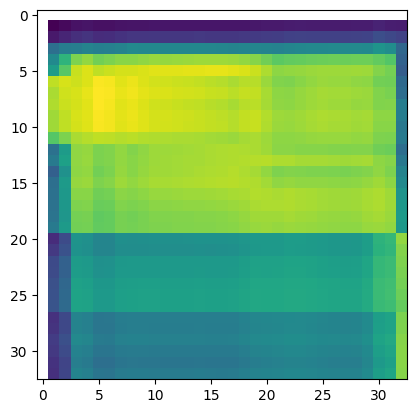

In [26]:
sims, cor_mtxs = rsa(hidden_states)
plt.imshow(sims.numpy())

## Other stuff (tbd)

In [6]:
set_seed(42)

###################
# data loaders
###################
raw_data = bound_alignment_sampler(
    tokenizer, 10000, [lower_bound_alignment_example_sampler]
)

raw_train = (
    raw_data[0][:8000],
    raw_data[1][:8000],
    raw_data[2][:8000],
    raw_data[3][:8000],
)
raw_eval = (
    raw_data[0][8000:9000],
    raw_data[1][8000:9000],
    raw_data[2][8000:9000],
    raw_data[3][8000:9000],
)
raw_test = (
    raw_data[0][9000:],
    raw_data[1][9000:],
    raw_data[2][9000:],
    raw_data[3][9000:],
)
train_dataset = Dataset.from_dict(
    {
        "input_ids": raw_train[0],
        "source_input_ids": raw_train[1],
        "labels": raw_train[2],
        "intervention_ids": raw_train[3],  # we will not use this field
    }
).with_format("torch")
train_dataloader = DataLoader(
    train_dataset,
    batch_size=16,
)
eval_dataset = Dataset.from_dict(
    {
        "input_ids": raw_eval[0],
        "source_input_ids": raw_eval[1],
        "labels": raw_eval[2],
        "intervention_ids": raw_eval[3],  # we will not use this field
    }
).with_format("torch")
eval_dataloader = DataLoader(
    eval_dataset,
    batch_size=16,
)
test_dataset = Dataset.from_dict(
    {
        "input_ids": raw_test[0],
        "source_input_ids": raw_test[1],
        "labels": raw_test[2],
        "intervention_ids": raw_test[3],  # we will not use this field
    }
).with_format("torch")
test_dataloader = DataLoader(
    test_dataset,
    batch_size=16,
)

### Boundless DAS on Position-aligned Tokens

In [7]:
def simple_boundless_das_position_config(model_type, intervention_type, layer):
    config = IntervenableConfig(
        model_type=model_type,
        representations=[
            RepresentationConfig(
                layer,              # layer
                intervention_type,  # intervention type
            ),
        ],
        intervention_types=BoundlessRotatedSpaceIntervention,
    )
    return config


config = simple_boundless_das_position_config(
    type(llama), "block_output", 15
)
intervenable = IntervenableModel(config, llama)
intervenable.set_device("cuda")
intervenable.disable_model_gradients()

In [8]:
t_total = int(len(train_dataloader) * 3)
warm_up_steps = 0.1 * t_total
optimizer_params = []
for k, v in intervenable.interventions.items():
    optimizer_params += [{"params": v[0].rotate_layer.parameters()}]
    optimizer_params += [{"params": v[0].intervention_boundaries, "lr": 1e-2}]
optimizer = torch.optim.Adam(optimizer_params, lr=1e-3)
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=warm_up_steps, num_training_steps=t_total
)


# You can define your custom compute_metrics function.
def compute_metrics(eval_preds, eval_labels):
    total_count = 0
    correct_count = 0
    for eval_pred, eval_label in zip(eval_preds, eval_labels):
        actual_test_labels = eval_label[:, -1]
        pred_test_labels = torch.argmax(eval_pred[:, -1], dim=-1)
        correct_labels = actual_test_labels == pred_test_labels
        total_count += len(correct_labels)
        correct_count += correct_labels.sum().tolist()
    accuracy = round(correct_count / total_count, 2)
    return {"accuracy": accuracy}


epochs = 3
gradient_accumulation_steps = 4
total_step = 0
target_total_step = len(train_dataloader) * epochs
temperature_start = 50.0
temperature_end = 0.1
temperature_schedule = (
    torch.linspace(temperature_start, temperature_end, target_total_step)
    .to(torch.bfloat16)
    .to("cuda")
)
intervenable.set_temperature(temperature_schedule[total_step])


def calculate_loss(logits, labels):
    shift_logits = logits[..., :, :].contiguous()
    shift_labels = labels[..., :].contiguous()
    # Flatten the tokens
    loss_fct = CrossEntropyLoss()
    shift_logits = shift_logits.view(-1, intervenable.model_config.vocab_size)
    shift_labels = shift_labels.view(-1)
    # Enable model parallelism
    shift_labels = shift_labels.to(shift_logits.device)
    loss = loss_fct(shift_logits, shift_labels)

    for k, v in intervenable.interventions.items():
        boundary_loss = 1.0 * v[0].intervention_boundaries.sum()
    loss += boundary_loss

    return loss

In [9]:
intervenable.model.train()  # train enables drop-off but no grads
print("llama trainable parameters: ", count_parameters(intervenable.model))
print("intervention trainable parameters: ", intervenable.count_parameters())
train_iterator = trange(0, int(epochs), desc="Epoch")
for epoch in train_iterator:
    epoch_iterator = tqdm(
        train_dataloader, desc=f"Epoch: {epoch}", position=0, leave=True
    )
    for step, inputs in enumerate(epoch_iterator):
        for k, v in inputs.items():
            if v is not None and isinstance(v, torch.Tensor):
                inputs[k] = v.to("cuda")
        b_s = inputs["input_ids"].shape[0]
        _, counterfactual_outputs = intervenable(
            {"input_ids": inputs["input_ids"]},
            [{"input_ids": inputs["source_input_ids"]}],
            {"sources->base": 80},  # swap 80th token
        )
        eval_metrics = compute_metrics(
            [counterfactual_outputs.logits], [inputs["labels"]]
        )

        # loss and backprop
        loss = calculate_loss(counterfactual_outputs.logits, inputs["labels"])
        loss_str = round(loss.item(), 2)
        epoch_iterator.set_postfix({"loss": loss_str, "acc": eval_metrics["accuracy"]})

        if gradient_accumulation_steps > 1:
            loss = loss / gradient_accumulation_steps
        loss.backward()
        if total_step % gradient_accumulation_steps == 0:
            if not (gradient_accumulation_steps > 1 and total_step == 0):
                optimizer.step()
                scheduler.step()
                intervenable.set_zero_grad()
                intervenable.set_temperature(temperature_schedule[total_step])
        total_step += 1

llama trainable parameters:  0
intervention trainable parameters:  16777218


Epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [23:23<00:00, 467.83s/it]


In [10]:
# evaluation on the test set
eval_labels = []
eval_preds = []
with torch.no_grad():
    epoch_iterator = tqdm(test_dataloader, desc=f"Test")
    for step, inputs in enumerate(epoch_iterator):
        for k, v in inputs.items():
            if v is not None and isinstance(v, torch.Tensor):
                inputs[k] = v.to("cuda")
        b_s = inputs["input_ids"].shape[0]
        _, counterfactual_outputs = intervenable(
            {"input_ids": inputs["input_ids"]},
            [{"input_ids": inputs["source_input_ids"]}],
            {"sources->base": 80},  # swap 80th token
        )
        eval_labels += [inputs["labels"]]
        eval_preds += [counterfactual_outputs.logits]
eval_metrics = compute_metrics(eval_preds, eval_labels)
print(eval_metrics)

Test: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:45<00:00,  1.38it/s]

{'accuracy': 0.96}
